In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import StratifiedKFold

import optuna

import lightgbm as lgb

In [61]:
df = pd.DataFrame()

l = ["data-2015.csv","data-2016.csv","data-2017.csv","data-2018.csv","data-2019.csv","data-2020.csv","data-2021.csv"]
for data in l:
    df_csv = pd.read_csv(f"data/{data}")
    df = pd.concat([df, df_csv])
df.index = np.arange(len(df))
df.drop_duplicates(subset=["id", "num"], inplace=True)

C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (98) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (95,96,98) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (33,34,44,45,48,95) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [57]:
df.drop_duplicates(subset=["id", "num"])

,num,nom,classement,id,date,url,tpsLastRace,last_race_dist,fer,firstTimeFer,...,tauxReclamation,distanceChevalPrecedent_libelleCourt,distanceChevalPrecedent_libelleLong,distanceChevalPrecedent_code,distanceChevalPrecedent_identifiant,nombrePlacesSecond,nombrePlacesTroisieme,eleveur,handicapValeur,poidsConditionMonte
0,1,VOLCANIA DE DYPP,0,2015010175001,2015-01-01,https://www.letrot.com/stats/fiche-cheval/volc...,9,2100,3,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,VICTOIRE SPEED,DA,2015010175001,2015-01-01,https://www.letrot.com/stats/fiche-cheval/vict...,10,3025,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,VELLA BLUE,5,2015010175001,2015-01-01,https://www.letrot.com/stats/fiche-cheval/vell...,19,2850,3,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,VENUS HAUFOR,4,2015010175001,2015-01-01,https://www.letrot.com/stats/fiche-cheval/venu...,27,2850,3,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,VOICE DREAM,0,2015010175001,2015-01-01,https://www.letrot.com/stats/fiche-cheval/voic...,19,2850,3,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144159,12,HARLEY GEMA,3,2021123175009,2021-12-31,https://www.letrot.com/stats/fiche-cheval/harl...,14,2175,2,False,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,Mme Marie-Annick SASSIER,NaN,NaN
144160,13,HAUTE COUTURE,6,2021123175009,2021-12-31,https://www.letrot.com/stats/fiche-cheval/haut...,19,3025,2,False,...,NaN,NaN,NaN,NaN,NaN,4.0,2.0,M. Jean-Philippe DUBOIS,NaN,NaN
144161,14,HORCHATA,7,2021123175009,2021-12-31,https://www.letrot.com/stats/fiche-cheval/horc...,14,2175,3,False,...,NaN,NaN,NaN,NaN,NaN,1.0,2.0,M. Ludovic FLEURY,NaN,NaN
144162,15,HELIA DU GARABIN,8,2021123175009,2021-12-31,https://www.letrot.com/stats/fiche-cheval/heli...,19,2050,2,False,...,NaN,NaN,NaN,NaN,NaN,2.0,0.0,M. René ALLUSSE,NaN,NaN


In [58]:
len(df)

144164

In [282]:
df["nbArrivé"]

0        11
1         7
2        12
3        12
4        11
         ..
87686    11
87687    12
87688    12
87689    11
87690     8
Name: nbArrivé, Length: 87691, dtype: int64

In [255]:
for i in range(1,3):
    df[f"M{i}"] = pd.to_numeric(df["music"].apply(lambda x: x.strip("[]").split(", ")[i])).replace(0,10)

In [257]:
df["M1"].unique()

array([ 3,  7,  1,  2, 10,  4,  6,  8,  9,  5], dtype=int64)

In [5]:
features = ['num',
            'id',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'avisTrainer',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 'handicapDistance',
 'gainsParticipant_gainsPlace',
 "dernierRapportReference_indicateurTendance",
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'dernierRapportReference_rapport',
 'nbCourseCouple',
 'nbVictoiresCouple',
 'nb2emeCouple',
 'nb3emeCouple',
 'txReussiteCouple']

In [6]:
len(features)

32

In [62]:
df_train = df.loc[:][features].apply(pd.to_numeric, errors="coerce")
y = df["classement"].replace(['DA', 'D1', 'A ',
       'D7', 'D8', 'H8', 'T ', 'G ', 'D5', 'D6', 'D', 'D3', 'D4', 'D2', 'D ',
       'G5', 'D9', 'H9', 'G4', 'R8', 'G6'], 10)

y = pd.to_numeric(y,downcast="integer",errors='coerce').fillna(10).replace(0,10).astype(np.int32)

ids = df.loc[:]["id"]
# df_train["dernierRapportReference_indicateurTendance"] = df_train["dernierRapportReference_indicateurTendance"].replace(["+", " ", "-"], [1, 0, -1]).fillna(0)


In [63]:
gss = GroupShuffleSplit(test_size=.40, n_splits=2, random_state = 7)

gss2 = GroupShuffleSplit(test_size=.40, n_splits=1, random_state = 7).split(df_train, y, groups=ids)

X_train_inds, X_test_inds = next(gss2)

train_data= df_train.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(['id'])]
y_train = y.iloc[X_train_inds]

groups = train_data.groupby('id').size().to_frame('size')['size'].to_numpy()

test_data = df_train.loc[:].iloc[X_test_inds]

#We need to keep the id for later predictions
X_test = test_data.loc[:, ~test_data.columns.isin(['id'])]
y_test = y.iloc[X_test_inds]

test_groups = test_data.groupby('id').size().to_frame('size')['size'].to_numpy()

In [180]:
gss.get_n_splits()

2

In [170]:
for train_idx, test_idx in gss.split(df_train,y, groups=ids):
    print("TRAIN:", train_idx, "TEST:", test_idx)

TRAIN: [    36     37     38 ... 144161 144162 144163] TEST: [     0      1      2 ... 144145 144146 144147]
TRAIN: [     0      1      2 ... 144145 144146 144147] TEST: [    49     50     51 ... 144161 144162 144163]


# Hyperparameter

In [183]:
from optuna.integration import LightGBMPruningCallback
from scipy import stats
import sklearn.metrics

def objective(trial):
    param_grid = {
    "n_estimators": trial.suggest_int("n_estimators", 100,2000),
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
    "num_leaves": trial.suggest_int("num_leaves", 20, 3000),
    "max_depth": trial.suggest_int("max_depth", -1, 500),
    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000),
    }
    model = lgb.LGBMRanker(n_jobs=24,objective="lambdarank",boosting_type = "dart",metric= "ndcg", **param_grid)
    
    scores = []
    
    for X_train_inds, X_test_inds in gss.split(df_train,y, groups=ids):
        train_data = df_train.iloc[X_train_inds]
        X_train = train_data.loc[:, ~train_data.columns.isin(['id'])]
        y_train = y.iloc[X_train_inds]
        groups = train_data.groupby('id').size().to_frame('size')['size'].to_numpy()
        
        test_data = df_train.iloc[X_test_inds]
        X_test = test_data.loc[:, ~test_data.columns.isin(['id'])]
        y_test = y.iloc[X_test_inds]
        test_groups = test_data.groupby('id').size().to_frame('size')['size'].to_numpy()
        
        model.fit(
            X_train,
            y_train,
            group = groups,
        )
        
        preds = model.predict(X_test)
        test_data["rank_pred"] = preds
        test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
        test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("first").astype(int)

        test_data["classement"] = y_test
        corr_coef = test_data[["classement", "rank_pred"]].corr(method="spearman")["classement"].loc["rank_pred"]
        preds_percentage = len(test_data.loc[test_data["rank_pred"] == 1].loc[test_data["classement"] == 1]) / len(test_data.groupby("id"))

        scores.append(corr_coef * preds_percentage)
        
    return np.mean(scores)

In [184]:
study = optuna.create_study(direction="maximize", study_name="LGBM Ranker")
func = lambda trial: objective(trial)
study.optimize(func, n_trials=2)

[I 2022-11-14 21:44:37,430] A new study created in memory with name: LGBM Ranker


[LightGBM] [Warning] min_data_in_leaf is set=790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=790


<ipython-input-183-c980ee84ff75>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-183-c980ee84ff75>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-183-c980ee84ff75>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=790


<ipython-input-183-c980ee84ff75>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-183-c980ee84ff75>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-183-c980ee84ff75>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=2844, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2844


<ipython-input-183-c980ee84ff75>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-183-c980ee84ff75>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-183-c980ee84ff75>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=2844, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2844


<ipython-input-183-c980ee84ff75>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-183-c980ee84ff75>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-183-c980ee84ff75>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [185]:
print('Number of finished trials:', len(study.trials))
print('Best Correlation', study.best_value)
print('Best trial:', study.best_trial.params)

Number of finished trials: 2
Best Correlation 0.18138638604081847
Best trial: {'n_estimators': 1894, 'learning_rate': 0.015482062204812644, 'num_leaves': 2839, 'max_depth': 403, 'min_data_in_leaf': 2844}


In [42]:
params = {'n_estimators': 300, 'learning_rate': 0.03044996692992604, 'num_leaves': 2960, 'max_depth': 349, 'min_data_in_leaf': 200}

In [186]:
gbm = lgb.LGBMRanker(objective="lambdarank",
                    boosting_type = "dart",
                    importance_type = "split",
                    n_jobs=24,
                    metric= "ndcg",
                    **study.best_trial.params)

In [197]:
gbm.fit(X_train, y_train, group=groups)

[LightGBM] [Warning] min_data_in_leaf is set=2844, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2844


LGBMRanker(boosting_type='dart', learning_rate=0.015482062204812644,
           max_depth=403, metric='ndcg', min_data_in_leaf=2844,
           n_estimators=1894, n_jobs=24, num_leaves=2839,
           objective='lambdarank')

In [198]:
list(test_data)

['num',
 'id',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'avisTrainer',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 'handicapDistance',
 'gainsParticipant_gainsPlace',
 'dernierRapportReference_indicateurTendance',
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'dernierRapportReference_rapport',
 'nbCourseCouple',
 'nbVictoiresCouple',
 'nb2emeCouple',
 'nb3emeCouple',
 'txReussiteCouple']

In [89]:
predictions = loaded_model.predict(X_test)
test_data["rank_pred"] = predictions
test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("first").astype(int)

test_data["classement"] = y_test

In [90]:
test_data[["classement", "rank_pred"]].corr(method="spearman")["classement"].loc["rank_pred"]

0.5493758438816991

In [91]:
len(test_data.loc[test_data["rank_pred"] == 1].loc[test_data["classement"] == 1]) / len(test_data.groupby("id"))

0.33726528647087145

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

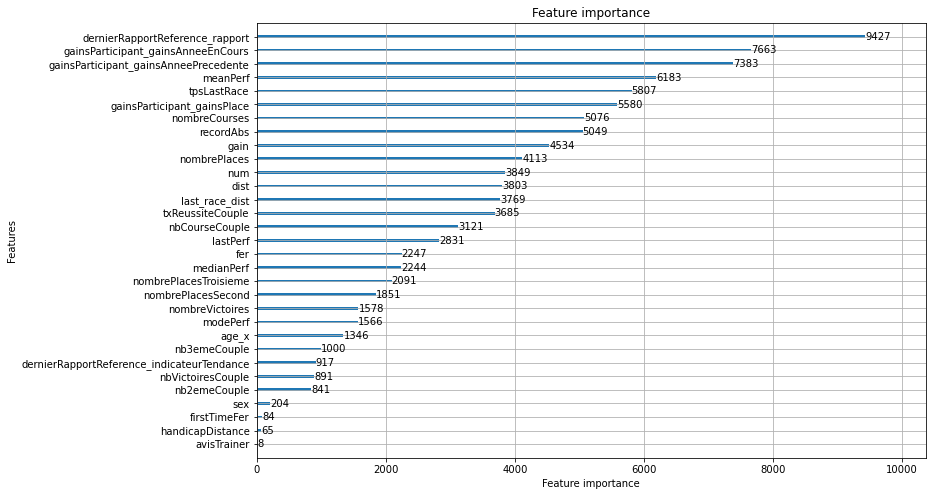

In [13]:
lgb.plot_importance(loaded_model, figsize = (12,8))

In [205]:
gbm.booster_.save_model("models/model_non_overfitted.txt")

In [65]:
def get_proba(rapport_min):
    n = len(test_data.loc[test_data["dernierRapportReference_rapport"] > rapport_min].loc[test_data["rank_pred"] == 1])
    p = len(test_data.loc[test_data["dernierRapportReference_rapport"] >= rapport_min].loc[test_data["rank_pred"] == 1].loc[test_data["classement"]==1]) / n
    return p, n

In [66]:
get_proba(20)

(0.3, 400)

In [45]:
np.mean([0.3,1/20])

0.175

In [25]:
class_rapport = np.arange(5,50,5)
nb_victoire = []
for i in class_rapport:
    nb_victoire.append( len(test_data.loc[test_data["rank_pred"] == 1].loc[test_data["classement"] == 1].loc[test_data["dernierRapportDirect_rapport"] < i ]) - sum(nb_victoire))

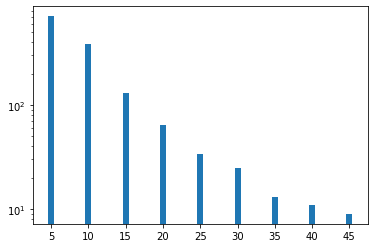

In [56]:
plt.bar(class_rapport,nb_victoire)
plt.yscale("log")

In [53]:
test_data.loc[test_data["rank_pred"] == 1].loc[test_data["classement"] == 1]

,num,id,tpsLastRace,last_race_dist,fer,firstTimeFer,sex,age_x,dist,avisTrainer,...,gainsParticipant_gainsAnneeEnCours,gainsParticipant_gainsAnneePrecedente,dernierRapportReference_rapport,nbCourseCouple,nbVictoiresCouple,nb2emeCouple,nb3emeCouple,txReussiteCouple,rank_pred,classement
222,4,2015010844132,25,2100,0,False,1,4,2275,2,...,NaN,NaN,NaN,3,2,1,0,100,1,1
665,12,2015011875003,24,2700,0,False,0,4,2700,2,...,0.0,15419000.0,3.5,2,2,0,0,100,1,1
809,11,2015011876168,10,3000,0,False,1,6,2850,2,...,0.0,2082000.0,16.0,1,1,0,0,100,1,1
844,18,2015011975008,28,3025,3,False,1,5,2700,2,...,0.0,3977000.0,4.6,1,1,0,0,100,1,1
888,12,2015011944048,20,2100,0,False,1,5,3025,2,...,0.0,2610000.0,2.6,1,1,0,0,100,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143894,6,2021122675002,11,2700,3,False,1,4,2175,2,...,6368000.0,3702000.0,2.5,5,2,1,2,100,1,1
143995,11,2021122814752,37,2575,0,False,0,4,2750,1,...,2225000.0,0.0,9.0,1,1,0,0,100,1,1
144109,1,2021123175001,18,2650,6,False,1,8,2100,2,...,1765000.0,2413000.0,26.0,1,1,0,0,100,1,1
144134,12,2021123175005,17,2100,0,False,1,3,2100,2,...,2700000.0,104000.0,11.0,4,2,1,0,75,1,1


In [92]:
G = test_data.groupby("id").apply(lambda g: g[(g["rank_pred"]) <= 2].loc[g["rank_pred"] == g["classement"]])

In [93]:
G.index = np.arange(len(G))
G

,num,id,tpsLastRace,last_race_dist,fer,firstTimeFer,sex,age_x,dist,avisTrainer,...,gainsParticipant_gainsAnneeEnCours,gainsParticipant_gainsAnneePrecedente,dernierRapportReference_rapport,nbCourseCouple,nbVictoiresCouple,nb2emeCouple,nb3emeCouple,txReussiteCouple,rank_pred,classement
0,4,2015010844138,114,2850,0,False,1,7,3000,2,...,0.0,1375000.0,18.0,3,1,1,1,100,2,2
1,12,2015011675008,24,2700,1,False,1,7,2875,2,...,0.0,3321000.0,6.5,4,1,2,0,75,2,2
2,12,2015011875003,24,2700,0,False,0,4,2700,2,...,0.0,15419000.0,3.5,2,2,0,0,100,1,1
3,11,2015011876168,10,3000,0,False,1,6,2850,2,...,0.0,2082000.0,16.0,1,1,0,0,100,1,1
4,9,2015011944045,78,2800,0,False,1,8,3000,2,...,0.0,900000.0,NaN,1,0,1,0,100,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2439,12,20170402510210,8,2700,3,False,1,6,2575,2,...,36000.0,2872000.0,3.2,1,1,0,0,100,1,1
2440,5,20171224750010,8,2100,0,False,1,3,2100,2,...,2661000.0,0.0,13.0,12,1,3,2,50,2,2
2441,13,20190113750010,21,2100,3,True,1,4,2850,2,...,0.0,3110000.0,3.5,11,1,2,2,45,2,2
2442,7,20190224750010,14,2925,3,False,1,7,2850,2,...,NaN,NaN,15.0,2,2,0,0,100,1,1


In [94]:
len(G.groupby("id").filter(lambda x: len(x) == 2))/2 / len(test_data.groupby("id"))

0.13216177178623015

In [85]:
len(G.groupby("id").filter(lambda x: len(x) == 2))/2

839.0

In [87]:
G.groupby("id").filter(lambda x: len(x) == 2)[["id", "num", "rank_pred", "classement"]]

,id,num,rank_pred,classement
0,2015010844132,4,1,1
1,2015010844132,5,2,2
7,2015012561029,4,1,1
8,2015012561029,16,2,2
9,2015020175008,5,2,2
...,...,...,...,...
2963,2021123175006,9,1,1
2964,20170402510210,1,2,2
2965,20170402510210,12,1,1
2967,20190224750010,7,1,1


In [201]:
features_pred = ['num',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'avisTrainer',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 'handicapDistance',
 'gainsParticipant_gainsPlace',
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'dernierRapportReference_indicateurTendance',
 'dernierRapportReference_rapport',
 'nbCourseCouple',
 'nbVictoiresCouple',
 'nb2emeCouple',
 'nb3emeCouple',
 'txReussiteCouple']

# Prédictions

In [152]:
loaded_model = lgb.Booster(model_file="models/modelv2.txt")

In [202]:
df_new = pd.read_csv("data-2022.csv")
df_new["classement"] = df_new["classement"].apply(pd.to_numeric, errors="coerce").replace(0.,10.).fillna(10.).astype(np.int32)
df_new["dernierRapportReference_indicateurTendance"] = df_new["dernierRapportReference_indicateurTendance"].replace(["+", " ", "-"], [1, 0, -1]).fillna(0).astype(np.int32)
df_new.drop_duplicates(subset=["id", "num"], inplace=True)
df_new.dropna(subset=["num"], inplace=True)
print("Nombre de course:",len(df_new.groupby("id")))
df_new.head() 

Nombre de course: 548


,num,nom,numCoursePMU,classement,id,date,url,tpsLastRace,last_race_dist,fer,...,tauxReclamation,poidsConditionMonte,handicapValeur,nomPereMere,handicapPoids,paysEntrainement,distanceChevalPrecedent_libelleCourt,distanceChevalPrecedent_libelleLong,distanceChevalPrecedent_code,distanceChevalPrecedent_identifiant
0,1,IMOKO AIMEF,R1C1,5,2022010175001,2022-01-01,https://www.letrot.com/stats/fiche-cheval/imok...,11,2700,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,IBIKI DE HOUELLE,R1C1,2,2022010175001,2022-01-01,https://www.letrot.com/stats/fiche-cheval/ibik...,18,2700,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,ICARE DES FORGES,R1C1,10,2022010175001,2022-01-01,https://www.letrot.com/stats/fiche-cheval/icar...,11,2700,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,IGUSKI SAUTONNE,R1C1,10,2022010175001,2022-01-01,https://www.letrot.com/stats/fiche-cheval/igus...,11,2700,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,INSTRUMENTALISTE,R1C1,1,2022010175001,2022-01-01,https://www.letrot.com/stats/fiche-cheval/inst...,18,2700,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
preds = loaded_model.predict(df_new.loc[:][features_pred])

df_new["pred"] = preds
df_new['pred'] = df_new.groupby("id")["pred"].rank("dense",ascending=True).astype(int)
df_new['pred'] = df_new.groupby("id")["pred"].rank("first").astype(int)

In [204]:
len(df_new[["id", "date", "num","classement", "pred"]].loc[(df_new["pred"] == 1) & (df_new["classement"] == 1)]) / len(df_new.groupby("id"))

0.41058394160583944

In [205]:
df_new.loc[(df_new["pred"] == 1) & (df_new["classement"] == 1)]["dernierRapportReference_rapport"].describe()

count    202.000000
mean       8.702475
std        8.782017
min        1.100000
25%        3.100000
50%        5.600000
75%       10.000000
max       51.000000
Name: dernierRapportReference_rapport, dtype: float64

In [206]:
G = df_new.groupby("id").apply(lambda g: g[(g["pred"]) <= 2].loc[g["pred"] == g["classement"]])
G.index = np.arange(len(G))

In [208]:
len(G.groupby("id").filter(lambda x: len(x) == 2))/2 / len(df_new.groupby("id"))

0.17883211678832117

6 9 522.5


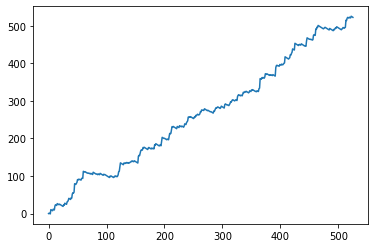

In [209]:
m_consecutive_loses = 0
m_consecutive_wins = 0

consecutive_loses = 0
consecutive_wins = 0


walk = [0]

for i, row in df_new.loc[df_new["pred"] == 1].iterrows():
    if row["classement"] != 1:
        consecutive_loses +=1
        m_consecutive_wins = max(m_consecutive_wins, consecutive_wins)
        consecutive_wins = 0
        
        walk.append(walk[-1] - 1)
    else:
        if not np.isnan(row["dernierRapportReference_rapport"]):
            walk.append(walk[-1] + int(row["dernierRapportReference_rapport"])/2)
            
        consecutive_wins += 1
        
        m_consecutive_loses = max(m_consecutive_loses, consecutive_loses)
        consecutive_loses = 0

print(m_consecutive_wins, m_consecutive_loses, walk[-1])
plt.plot(walk)

In [208]:
today = pd.read_csv("today.csv", index_col=0)
today_feat = today.loc[:][features_pred]
today_feat["dernierRapportReference_indicateurTendance"] = today_feat["dernierRapportReference_indicateurTendance"].replace(["+", " ", "-"], [1, 0, -1]).fillna(0)
today_feat = today_feat.apply(pd.to_numeric, errors="coerce")
today_feat

,num,tpsLastRace,last_race_dist,fer,firstTimeFer,sex,age_x,dist,avisTrainer,lastPerf,...,gainsParticipant_gainsPlace,dernierRapportReference_indicateurTendance,gainsParticipant_gainsAnneeEnCours,gainsParticipant_gainsAnneePrecedente,dernierRapportReference_rapport,nbCourseCouple,nbVictoiresCouple,nb2emeCouple,nb3emeCouple,txReussiteCouple
0,1.0,72,2800,3,False,1,7,2650,3,0,...,2090000.0,1.0,0.0,0.0,52.0,7,0,0,0,0
1,2.0,8,2725,2,False,1,7,2650,2,6,...,3857000.0,1.0,789000.0,987000.0,25.0,12,0,1,2,25
2,3.0,14,2725,3,False,1,7,2650,2,2,...,2622500.0,0.0,1023500.0,628000.0,2.5,10,2,2,2,60
3,4.0,14,2725,2,False,1,7,2650,2,5,...,2604000.0,0.0,1443000.0,417000.0,8.9,15,4,0,1,33
4,5.0,29,2650,3,False,1,8,2650,2,8,...,3887000.0,-1.0,476000.0,907000.0,16.0,9,0,0,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,12.0,8,2875,3,False,1,6,2450,1,7,...,NaN,0.0,NaN,NaN,NaN,0,0,0,0,0
12,13.0,15,2825,0,False,1,6,2450,3,0,...,NaN,0.0,NaN,NaN,NaN,3,0,0,1,33
13,14.0,97,2725,0,False,1,6,2450,3,4,...,NaN,0.0,NaN,NaN,NaN,12,0,1,1,16
14,15.0,8,2875,0,False,1,6,2450,3,8,...,NaN,0.0,NaN,NaN,NaN,7,0,1,2,42


In [31]:
today.loc[today["numCoursePMU"] == "R10C3"]["dernierRapportDirect_rapport"]

0     29.5
1     61.1
2     67.3
3      6.3
4      3.8
5     68.7
6      7.7
7      6.5
8     41.1
9      5.0
10    31.3
11     8.0
Name: dernierRapportDirect_rapport, dtype: float64

In [151]:
list(today)

['num',
 'nom',
 'id',
 'date',
 'url',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'driver_x',
 'trainer',
 'avisTrainer',
 'music',
 'nbArrivé',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'numPmu',
 'age_y',
 'sexe',
 'race',
 'statut',
 'oeilleres',
 'proprietaire',
 'entraineur',
 'driver_y',
 'driverChange',
 'indicateurInedit',
 'musique',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 'nomPere',
 'nomMere',
 'jumentPleine',
 'engagement',
 'supplement',
 'handicapDistance',
 'poidsConditionMonteChange',
 'urlCasaque',
 'eleveur',
 'allure',
 'avisEntraineur',
 'robe_code',
 'robe_libelleCourt',
 'robe_libelleLong',
 'gainsParticipant_gainsCarriere',
 'gainsParticipant_gainsVictoires',
 'gainsParticipant_gainsPlace',
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'dernierRapportDirect_typePari',
 'dernierRappor

In [209]:
pred_today = gbm.predict(today_feat)

In [210]:
today["pred"] = pred_today
today['pred'] = today.groupby("id")["pred"].rank("dense",ascending=True).astype(int)
today['pred'] = today.groupby("id")["pred"].rank("first").astype(int)

In [34]:
today.loc[today["numCoursePMU"] == "R4C4"].sort_values(by="pred")[["num","numCoursePMU" ,"nom", "pred"]]

,num,numCoursePMU,nom,pred
4,5,R4C4,JEWEL D'AUCHY,1
2,3,R4C4,JAVA DU MONCEL,2
5,6,R4C4,JET MENCOURT,3
9,10,R4C4,JUSTIN BOLD,4
3,4,R4C4,JULIA QUESNOT,5
8,9,R4C4,JOY BLUE,6
6,7,R4C4,JAGGERA BOMB,7
0,1,R4C4,JALDO D'OCQUE,8
1,2,R4C4,JARVIS,9
7,8,R4C4,JINGLE GEDE,10


In [160]:
groupe_len = today[["num", "nom","pred","id","url"]].groupby("id").size()

In [211]:
winners = today[["numCoursePMU","num", "nom","dernierRapportReference_rapport","pred"]].loc[today["pred"]==1]
winners

,numCoursePMU,num,nom,dernierRapportReference_rapport,pred
2,R1C1,3,FOX DU RIB,2.5,1
12,R1C3,13,IGNACE GUENESERIE,15.0,1
7,R1C6,8,HAUT BRION CODIE,7.9,1
5,R1C7,6,FARSIGHT ABSOLUTE,9.1,1
1,R1C8,2,DOLLAR DU CAUX,16.0,1
12,R4C1,13,DIWI D'OCCAGNES,7.4,1
4,R4C2,5,HYTHO D'ALCI,14.0,1
7,R4C3,8,INEDIT DU GADE,8.0,1
3,R4C4,4,JULIA QUESNOT,2.5,1
10,R4C5,11,GINKGO DES GRANGES,9.5,1


In [22]:
winners2 = winners.dropna()
winners2

,numCoursePMU,num,nom,dernierRapportReference_rapport,pred
2,R1C1,3,FOX DU RIB,2.5,1
12,R1C3,13,IGNACE GUENESERIE,15.0,1
0,R1C6,1,HAUTAIN DE HOUELLE,19.0,1
5,R1C7,6,FARSIGHT ABSOLUTE,9.1,1
9,R1C8,10,ETOILE ROUGE,14.0,1
12,R4C1,13,DIWI D'OCCAGNES,7.4,1
4,R4C2,5,HYTHO D'ALCI,14.0,1
7,R4C3,8,INEDIT DU GADE,8.0,1
3,R4C4,4,JULIA QUESNOT,2.5,1
13,R4C5,14,GERONIMO STARDUST,8.6,1


In [30]:
def kelly(rapport, capital, p):
    return p-(1-p)/rapport

In [47]:
kelly(50,250,0.1) * 250

20.5

In [34]:
capital = 25
winners2["mises"] = winners2["dernierRapportReference_rapport"].apply(lambda x: kelly(x, capital, get_proba(x-5,x+5)) * capital)
winners2

<ipython-input-34-133932dede4e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winners2["mises"] = winners2["dernierRapportReference_rapport"].apply(lambda x: kelly(x, capital, get_proba(x-5,x+5)) * capital)


,numCoursePMU,num,nom,dernierRapportReference_rapport,pred,mises
2,R1C1,3,FOX DU RIB,2.5,1,6.682555
12,R1C3,13,IGNACE GUENESERIE,15.0,1,7.534351
0,R1C6,1,HAUTAIN DE HOUELLE,19.0,1,6.977276
5,R1C7,6,FARSIGHT ABSOLUTE,9.1,1,7.144606
9,R1C8,10,ETOILE ROUGE,14.0,1,6.187708
12,R4C1,13,DIWI D'OCCAGNES,7.4,1,8.016579
4,R4C2,5,HYTHO D'ALCI,14.0,1,6.187708
7,R4C3,8,INEDIT DU GADE,8.0,1,7.758526
3,R4C4,4,JULIA QUESNOT,2.5,1,6.682555
13,R4C5,14,GERONIMO STARDUST,8.6,1,7.234860


In [139]:
winners["mises"] * winners["dernierRapportDirect_rapport"]

11     28.188602
10     16.208354
0     150.000000
13     77.932422
10     20.670172
11    144.349776
6      31.152423
dtype: float64

In [35]:
winners2["mises"].sum()

77.49185597503941

In [44]:
rapport = 8
kelly(rapport,25,get_proba(rapport-5,rapport+5)) * 25

7.758526453869699